## Downloading packages

In [ ]:
!pip install trimesh
!pip install --upgrade ipywidgets

## Mounting to Google Drive

In [ ]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'MyDrive/Colab Notebooks/Machine Learning and Deep Learning/Project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Creating custom dataset

In [ ]:
import os
import yaml
import numpy as np
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    def __init__(self, dataset_root,
                       models_root,
                       split='train',
                       train_ratio=0.8,
                       seed=42,
                       img_size=(224,224)): # ResNet wants this size.

        self.dataset_root = dataset_root
        self.models_root = models_root
        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}

        # Paths to images, rgb + depth.
        self.rgb_dir = os.path.join(dataset_root, 'rgb')
        self.depth_dir = os.path.join(dataset_root, 'depth')

        # Paths to .yaml-files.
        self.gt_path = os.path.join(dataset_root, 'gt.yml')
        self.info_path = os.path.join(dataset_root, 'info.yml')

        # Load ground truth pose.
        with open(self.gt_path, 'r') as f:
            self.gt = yaml.load(f, Loader=yaml.FullLoader)

        # Load camera intrinsics.
        with open(self.info_path, 'r') as f:
            self.info = yaml.load(f, Loader=yaml.FullLoader)

         # Load models_info.yml.
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.load(f, Loader=yaml.FullLoader)

        # Sorting in a way that aviods mismatches if dataloader converting to string.
        self.samples = sorted([int(k) for k in self.gt.keys()])

        # Checking if samples were found.
        if not self.samples:
            raise ValueError(f"No samples found in {self.dataset_root}. Check the dataset path and structure.")

        # Splitting into training and test sets.
        self.train_samples, self.test_samples = train_test_split(
            self.samples, train_size=self.train_ratio, random_state=self.seed
        )

        # Selecting the appropriate split.
        self.samples = self.train_samples if split == 'train' else self.test_samples

        # Defining image transformations.
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    # Returning the length of the split.
    def __len__(self):
        return len(self.samples)

    # Returning how many different objects annotated in the dataset.
    def how_many_objects(self):
        return len(self.gt[0])

    # Returning the ID:s of the different objects annotated in the dataset.
    def objectTypes(self):
        ids = []
        for ann in self.gt[0]:
            ids.append(f"{ann['obj_id']:02}")
        return ids

    # Returning the model info from the .yaml-file.
    def get_model_info(self, object_id):
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not found in models_info.yml")
        return self.models_info[object_id]

    # Loading the 3D model from the -yaml-file.
    def load_3D_model(self, object_id):
        if object_id in self.models:
            # If model have been loaded before.
            return self.models[object_id]
        else:
            # If model haven't been loaded before.
            print(f"Adding model of object id {object_id} to list")
            model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
            mesh = trimesh.load(model_path)
            points = mesh.vertices.astype(np.float32)
            # Converting from (mm) into (m).
            points = points / 1000.0
            # Add to the list for fast fetching next time.
            self.models[object_id] = points
            return points

    # Accessing the intrinsic matrix for the specific index.
    def get_intrinsic_matrix(self, idx):
        cam_K = self.info[idx]['cam_K']
        cam_K = np.array(cam_K).reshape((3, 3))  # Reshape to 3x3 matrix
        return torch.tensor(cam_K, dtype=torch.float32)

    def cropImages(self, image, annotations, sample_id):
        crop_entries = []
        org_K = self.get_intrinsic_matrix(sample_id)

        # Looping over all annotations for each image.
        for ann in annotations:
            bbox = ann['obj_bb']
            x, y, w, h = bbox
            width, height = image.size

            # Clamping to image bounds.
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            # Cropping image.
            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            # Adjusting original K to the crop offset.
            cropped_K = org_K.clone()
            cropped_K[0, 2] -= x1  # Adjust cx.
            cropped_K[1, 2] -= y1  # Adjust cy.

            # Resizing image.
            cropped = cropped.resize(self.img_size, Image.BILINEAR)

            # Adjusting K for resize.
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height
            cropped_K[0, 0] *= scale_x  # fx
            cropped_K[0, 2] *= scale_x  # cx
            cropped_K[1, 1] *= scale_y  # fy
            cropped_K[1, 2] *= scale_y  # cy

            # Applying transformations.
            cropped_rgb_tensor = self.transform(cropped)

            # Receiving R_mat and t_vec.
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000

            # Normalizing the boundry box.
            w = x2 - x1
            h = y2 - y1
            norm_bbox = torch.tensor([
                x1 / width,
                y1 / height,
                w / width,
                h / height
            ], dtype=torch.float32)

            # Appending all of the relevant entries.
            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': bbox,
                'norm_bbox': norm_bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, org_K

    # Fetching a specific item in the dataset.
    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        sample_str = f"{sample_id:04d}"

        # Loading images.
        rgb_path = os.path.join(self.rgb_dir, sample_str + '.png')
        org_rgb = Image.open(rgb_path).convert("RGB")

        # Fetching annotations from gt.yml.
        annotations = self.gt[sample_id]

        crop_rgbs_and_ann, org_K = self.cropImages(org_rgb, annotations, sample_id)

        return {
                    'sample_id': sample_id,
                    'original_rgb': org_rgb,
                    'original_K': org_K,
                    'objects': crop_rgbs_and_ann  # list of dicts, one per object.
                }

## PoseNet6D using ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class PoseNet6D_wR18(nn.Module):
    def __init__(self, img_size=(224, 224), weights=ResNet18_Weights.DEFAULT):
        super(PoseNet6D_wR18, self).__init__()
        self.img_size = img_size

        # Loading a pretrained ResNet18 model and removing the final classification layers.
        resnet = resnet18(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Outputs [B, 512, 7, 7]

        # Global average pooling to reduce spatial dimensions to 1x1.
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Outputs [B, 512, 1, 1]

        # Total feature size after concatenating bbox input: 512 from ResNet + 4 from the bbox.
        fused_dim = 512 + 4

        # Fully connected layers for depth estimation from the fused features.
        self.fc_depth = nn.Sequential(
            nn.Linear(516, 256),       # 512 image features + 4 bbox coordinates.
            nn.BatchNorm1d(256),       # Normalizing to stabilize training.
            nn.ReLU(),                 # Adding a non-linearity.
            nn.Linear(256, 1)          # Predicting a scalar depth value.
        )

        # Fully connected layers for predicting rotation (as quaternion).
        self.fc_rotation = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)          # Quaternion has 4 components.
        )

    def forward(self, x_img, norm_bbox, K_crop):
        B = x_img.shape[0]

        # Extracting features from image using the ResNet18 backbone.
        x = self.backbone(x_img)                # [B, 512, 7, 7]
        x = self.global_pool(x).view(B, -1)     # [B, 512], flatten pooled features.

        # Concatenating the normalized bounding box with image features.
        x = torch.cat([x, norm_bbox], dim=1)    # [B, 516]

        # Predicting depth and clamping it to a reasonable range for stability.
        depth = self.fc_depth(x).squeeze(1)     # [B]
        depth = torch.clamp(depth, min=0.1, max=1.5)  # Preventing zero value or overly large depth.

        # Predicting normalized quaternion for rotation.
        quat = F.normalize(self.fc_rotation(x), dim=1)  # [B, 4]

        # Extracting camera intrinsics from cropped intrinsics matrix.
        fx = K_crop[:, 0, 0]
        fy = K_crop[:, 1, 1]
        cx_crop = K_crop[:, 0, 2]
        cy_crop = K_crop[:, 1, 2]

        # Computing pixel center of bounding box in image space.
        img_w, img_h = self.img_size
        u = (norm_bbox[:, 0] + 0.5 * norm_bbox[:, 2]) * img_w
        v = (norm_bbox[:, 1] + 0.5 * norm_bbox[:, 3]) * img_h

        # Backproject center pixel to 3D camera coordinates using intrinsics and predicted depth.
        x_cam = (u - cx_crop) * depth / fx
        y_cam = (v - cy_crop) * depth / fy
        z_cam = depth

        # Stacking to form the translation vector [x, y, z].
        translation = torch.stack([x_cam, y_cam, z_cam], dim=1)  # [B, 3]

        return translation, quat


## Helper functions

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    # Converting all inputs into NumPy.
    def to_np(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    R_pred, t_pred = to_np(R_pred), to_np(t_pred)
    R_gt, t_gt = to_np(R_gt), to_np(t_gt)
    model_points = to_np(model_points)

    # Transforming model points.
    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt

    # Returning ADD for the prediction.
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()

def quaternion_to_matrix_batch(quat):
    # Adding the batch dimension if single quaternion.
    if quat.dim() == 1:
        quat = quat.unsqueeze(0)

    # Extracting the elements.
    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0) # Re-shaping.
    R = torch.zeros((B, 3, 3), device=quat.device)

    # Calculating elementswise.
    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    if quat.dim() == 1:
        R = R.squeeze(0)  # Remove batch dimension if single quaternion.

    return R

def quaternion_loss(quat_pred, quat_gt):
    # Normalizing.
    quat_pred = F.normalize(quat_pred, dim=1)
    quat_gt = F.normalize(quat_gt, dim=1)
    dot = torch.sum(quat_pred * quat_gt, dim=1)
    # Clamping results to avoid unrealistic results.
    dot = torch.clamp(dot, -1.0 + 1e-4, 1.0 - 1e-4)
    loss = 1 - dot**2  # Minimizes angular difference.
    return loss.mean()

def quaternion_angular_error(q1, q2):
    dot = torch.sum(q1 * q2, dim=1).clamp(-1.0, 1.0)
    dot = torch.abs(dot)  # Handling the ±q ambiguity.
    angle = 2 * torch.acos(dot) * (180.0 / torch.pi)  # Radians → degrees.
    return angle

def computeMSE(rot_pred, t_pred, rot_gt, t_gt, quat=False,
               weight_xyz=(1.0, 1.0, 0.1), beta=1.0, print_mse=False):
    # Clamping predictions to avoid log(0).
    t_pred = torch.clamp(t_pred, min=1e-3)
    t_gt = torch.clamp(t_gt, min=1e-3)

    # Calculating weighted, per-axis translation loss.
    x_loss = F.mse_loss(t_pred[:, 0], t_gt[:, 0]) * weight_xyz[0]
    y_loss = F.mse_loss(t_pred[:, 1], t_gt[:, 1]) * weight_xyz[1]
    # Here we're using log to smooth out z-loss.
    z_loss = F.mse_loss(torch.log(t_pred[:, 2]), torch.log(t_gt[:, 2])) * weight_xyz[2]

    # Summing translational losses.
    translation_loss = x_loss + y_loss + z_loss

    # Calculating the rotational loss.
    if quat:
        rotation_loss = quaternion_loss(rot_pred, rot_gt)
    else:
        rot_diff = torch.bmm(rot_pred.transpose(1, 2), rot_gt)
        identity = torch.eye(3, device=rot_pred.device).unsqueeze(0).expand(rot_pred.size(0), -1, -1)
        rotation_loss = F.mse_loss(rot_diff, identity)

    total_loss = translation_loss + beta * rotation_loss

    # Printing results.
    if print_mse:
        print(f"X loss:           {x_loss:.6f}")
        print(f"Y loss:           {y_loss:.6f}")
        print(f"Z loss:           {z_loss:.6f}")
        print(f"Rotation loss:    {rotation_loss:.6f}")
        print(f"Total loss:       {total_loss:.6f}")
        if quat:
            angle_deg = quaternion_angular_error(rot_pred, rot_gt).mean().item()
            print(f"Angular error (deg): {angle_deg:.2f}")

    return total_loss

def flatten_collate_fn(batch):
    flat_data = []
    # Looping over all samples in all batches.
    for sample in batch:
        for obj in sample['objects']:
            # Extracting relevant entries.
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id'],
                'bbox': obj['norm_bbox'].clone().detach(),
                'cropped_K': obj['cropped_K'].clone().detach()
            })
    # Stacking all fields into one dict.
    rgb = torch.stack([item['rgb'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)
    bbox = torch.stack([item['bbox'] for item in flat_data])
    cropped_K = torch.stack([item['cropped_K'] for item in flat_data])

    return {
          'rgb': rgb,
          'rotation': rotation,
          'translation': translation,
          'object_id': object_ids,
          'norm_bbox': bbox,
          'cropped_K': cropped_K
      }

## Dataloaders

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import numpy as np

# Path to the dataset.
dataset_nr = "14" # Which dataset do you want to train on?
dataset_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/data', dataset_nr)

# Path to the 3D-models library.
models_root = os.path.join(full_project_path, 'dataset/LineMOD/Linemod_preprocessed/models')

# Create datasets.
print(f"Loading dataset {dataset_nr}")
train_dataset = PoseEstimationDataset(dataset_root, models_root, split='train')
test_dataset = PoseEstimationDataset(dataset_root, models_root, split='test')
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"This dataset consists of annotated data for {train_dataset.how_many_objects()} item(s).")
print(f"The following objects are included: {train_dataset.objectTypes()}")

# Defining dataloaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=flatten_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate_fn)

Loading dataset 14
Training dataset size: 981
Testing dataset size: 246
This dataset consists of annotated data for 1 item(s).
The following objects are included: ['14']
Mean translation: [-0.03572468, 0.00231825, 0.8771876]
Std translation: [0.09174806, 0.07563744, 0.12476383]


## Functions for training and evaluation

In [ ]:
from tqdm import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    first_round = True

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):
        rgb = data['rgb'].to(device)
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)
        bbox = data['norm_bbox'].to(device)
        cropped_K = data['cropped_K'].to(device)

        # Forward pass of PoseNet.
        t_pred, quat_pred = model(rgb, bbox, cropped_K)

        # Converting into quaternion.
        quat_gt = matrix_to_quaternion_batch(R_gt)

        # Setting dynamical weights for better convergence.
        if epoch < 5:
            beta = 1
            weight_xyz = (0, 0, 0.1)
        elif epoch < 10:
            beta = 5
            weight_xyz = (0.5, 0.5, 0.4)
        else:
            beta = 10
            weight_xyz = (0.1, 0.1, 1)

        # Calculating the MSE loss.
        loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt,
                  quat=True, weight_xyz=weight_xyz, beta=beta)

        optimizer.zero_grad()

        # Gradient clipping to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Train Epoch: {epoch} -> Loss: {train_loss:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device):
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0
    first_round = True

    with torch.no_grad():
        for data in val_loader:
            rgb = data['rgb'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']
            bbox = data['norm_bbox'].to(device)
            cropped_K = data['cropped_K'].to(device)

            t_pred, quat_pred = model(rgb, bbox, cropped_K)
            quat_gt = matrix_to_quaternion_batch(R_gt)

            # Converting quat_pred into a proper rotation matrix.
            R_pred = quaternion_to_matrix_batch(quat_pred)

            # Calculating MSE loss.
            loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt, quat=True, print_mse=first_round)

            first_round = False
            running_loss += loss.item()

            # Looping over the batch.
            for i in range(rgb.size(0)):
                obj_id = int(object_ids[i])
                # Fetching model points.
                model_points = torch.tensor(dataset.load_3D_model(obj_id),
                                            dtype=torch.float32).to(device)
                # Computing ADD for each image.
                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                add_total += add
                num_samples += 1

    # Averaging results.
    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples

    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')
    return avg_loss, avg_add

## Training

In [ ]:
import matplotlib.pyplot as plt
from torch import nn, optim

SAVE_LOCAL = True
SAVE_DRIVE = True

if __name__ == "__main__":

    checkpoint_path = os.path.join(full_project_path, "models/checkpoint.pth")

    # Defining device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print("<<<<<<Using GPU>>>>>>")
    else:
        print("<<<<<<Using CPU>>>>>>")

    # Creating instance of PoseNet6D.
    model = PoseNet6D_wR18() # Use ResNet18 (lighter)
    model.to(device)

    # Defining the optimizer.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.001, weight_decay=0.005)

    # Defining learning rate scheduler.
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Initiating loss tracking.
    train_losses = []
    add_losses = []
    best_add = float('inf')  # Initializing with a high value.
    counter = 0

    # How long would you like to train?
    patience = 20
    num_epochs = 65

    # See if there's a checkpoint to load.
    if os.path.exists("/content/checkpoint.pth"):
        checkpoint = torch.load("/content/checkpoint.pth",
                                map_location=device,
                                weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_add = checkpoint['best_val_loss']
        add_losses = checkpoint['add_losses']
        train_losses = checkpoint['train_losses']
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        start_epoch = 1  # If no checkpoint, start from the beginning
        print("No checkpoint found, starting from epoch 1.")

    # Training loop.
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")
        print(f">>>>>>>Current best ADD is {best_add:.4f}<<<<<<<<<")

        # ----- TRAINING -----
        model = train_model(epoch, model, train_loader, computeMSE, optimizer, device)

        # --- EVALUATING ---
        avg_loss, avg_add = evaluate_model(model, test_loader, test_dataset, device)
        train_losses.append(avg_loss)
        add_losses.append(avg_add)

        # ----- SAVING THE BEST MODEL -----
        if avg_add < best_add:
            best_add = avg_add
            counter = 0
            torch.save(model.state_dict(), "/content/best_posenet.pt")
            print(f"✅ New best ADD: {avg_add:.4f} (saved model locally)")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # Saving each checkpoint.
        checkpoint = {
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'best_val_loss': best_add,
                          'add_losses': add_losses,
                          'train_losses': train_losses
                      }
        if SAVE_LOCAL:
            torch.save(checkpoint, "/content/checkpoint.pth")
            print("💾 Checkpoint saved locally.")
        if SAVE_DRIVE:
            torch.save(checkpoint, checkpoint_path)
            print("☁️ Checkpoint saved on Google Drive.")

        # ----- UPDATING LEARNING RATE -----
        lr_scheduler.step(avg_loss)

        print(f"Epoch {epoch}/{num_epochs} | Average ADD: {avg_add:.4f}")

    # -----PLOTTING RESULTS-----
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(train_losses, 'g-', label='MSE Loss')
    ax2.plot(add_losses, 'b-', label='ADD')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss', color='g')
    ax2.set_ylabel('ADD (m)', color='b')
    plt.title("Training Loss and Validation ADD")
    plt.grid(True)
    plt.show()

<<<<<<Using GPU>>>>>>
No checkpoint found, starting from epoch 1.

--------- Starting Epoch 1/65 ---------
>>>>>>>Current best ADD is inf<<<<<<<<<


Epoch 1:  39%|███▊      | 12/31 [05:43<09:03, 28.62s/batch]

## Try out the model


GT t: [ 0.09654023 -0.07226685  0.8505636 ]
GT R:
[[-0.911602 -0.357186  0.203471]
 [-0.338157  0.370155 -0.865237]
 [ 0.233734 -0.857557 -0.458218]]
Pred t: [ 0.14323388 -0.07631639  0.94742036]
Pred R:
[[-0.9104209  -0.40734258  0.07215643]
 [-0.23212126  0.3586346  -0.90415776]
 [ 0.3424241  -0.8399128  -0.42106152]]
Adding model of object id 13 to list
--------Object ID 13---------
---> ADD: 0.107269
---> Angular error: 6.7223


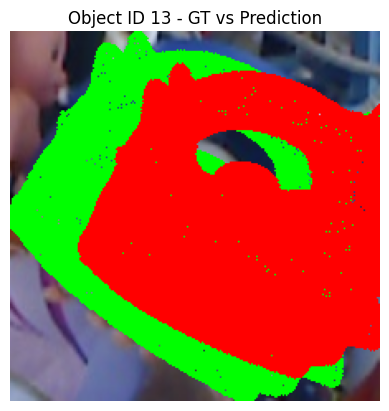

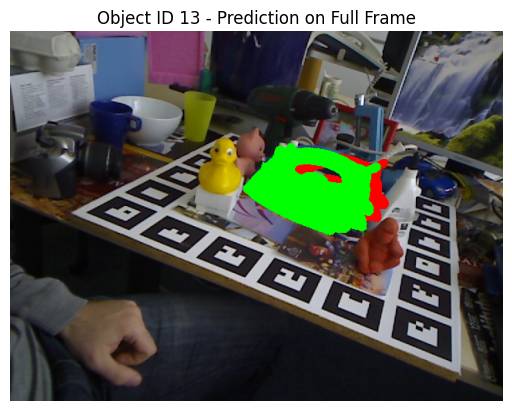

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load model.
model = PoseNet6D_wR18() # use ResNet18
#model = PoseNet6D_wR50() # use ResNet50
model.load_state_dict(torch.load('/content/best_posenet.pt'))

# If we have a GPU, move the model to the device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

obj_id = 13
eval_dataset_id = "13" # 02, 03, 07 is missing.
DRAW_AXES = False
DRAW_MODELS = True
eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one sample (may contain multiple objects)
img_idx = 20
data_item = dataset[img_idx]
original_image = np.array(data_item['original_rgb'])
original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)  # For OpenCV

import cv2
import numpy as np

def draw_axes(image, R, t, K, is_gt=False, axis_length=0.05, thickness=2):
    # Define 3D points for axes
    axes_3d = np.array([
        [0, 0, 0],  # origin
        [axis_length, 0, 0],  # x-axis
        [0, axis_length, 0],  # y-axis
        [0, 0, axis_length]   # z-axis
    ], dtype=np.float32)

    # Transform and project 3D points
    pts_2d = (K @ (axes_3d @ R.T + t).T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    pts_2d = pts_2d.astype(int)

    # Origin point
    o = tuple(pts_2d[0])

    # Draw white dot at the origin
    cv2.circle(image, o, 6, (255, 255, 255), -1)


    # GT dashed or lighter colors
    if is_gt:
        color_x = (100, 100, 255)  # Light red
        color_y = (100, 255, 100)  # Light green
        color_z = (255, 100, 100)  # Light blue
    else:
        color_x = (0, 0, 255)  # Red
        color_y = (0, 255, 0)  # Green
        color_z = (255, 0, 0)  # Blue

    cv2.circle(image, o, 3, (255, 255, 255), -1)
    cv2.line(image, o, tuple(pts_2d[1]), color_x, thickness)
    cv2.line(image, o, tuple(pts_2d[2]), color_y, thickness)
    cv2.line(image, o, tuple(pts_2d[3]), color_z, thickness)

    return image


# For each object in the image
for obj in data_item['objects']:
    if obj['object_id'] != obj_id:
        continue
    cropped_rgb_tensor = obj['cropped_rgb'].unsqueeze(0).to(device)
    cropped_K = obj['cropped_K']
    R_gt = obj['rotation']
    t_gt = obj['translation']
    obj_id = obj['object_id']
    norm_bbox = obj['norm_bbox']

    # Forward pass
    #t_pred, R_pred = model(cropped_rgb_tensor)
    t_pred, quat_pred = model(cropped_rgb_tensor,
                              norm_bbox.unsqueeze(0).to(device),
                              cropped_K.unsqueeze(0).to(device))

    # Convert to numpy.
    R_gt_tensor = torch.tensor(R_gt, dtype=torch.float32).to(device)
    quat_gt = matrix_to_quaternion_batch(R_gt_tensor)
    R_pred = quaternion_to_matrix_batch(quat_pred)
    ang_err = quaternion_angular_error(quat_pred, quat_gt)

    # Turn into numpy.
    t_pred = t_pred.detach().cpu().numpy().squeeze()
    R_pred = R_pred.detach().cpu().numpy().squeeze()
    cropped_K = cropped_K.detach().cpu().numpy()

    # Show the results for this image.
    print(f"\nGT t: {t_gt.T}")
    print(f"GT R:\n{R_gt}")
    print(f"Pred t: {t_pred.T}")
    print(f"Pred R:\n{R_pred}")

    # Load correct model
    model_points = torch.from_numpy(dataset.load_3D_model(obj_id)).to(device)
    model_points_np = model_points.detach().cpu().numpy() # Turn into numpy.

    # Project model points
    def project(pts, R, t, K):
        proj = (K @ (pts @ R.T + t).T).T
        return proj[:, :2] / proj[:, 2:3]

# ------ PLOTTING IN CROPPED IMAGE ------

    # Visualize on cropped image.
    vis = obj['cropped_rgb'].cpu().numpy().transpose(1, 2, 0)
    vis = (vis * 0.229 + 0.485).clip(0, 1)  # Unnormalize
    vis = (vis * 255).astype(np.uint8)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)

    if DRAW_AXES:
      vis = draw_axes(vis, R_pred, t_pred, cropped_K)
      vis = draw_axes(vis, R_gt, t_gt, cropped_K)

    if DRAW_MODELS:
        # Project 3D model points to 2D
        pts_gt = project(model_points_np, R_gt, t_gt, cropped_K).astype(int)
        pts_pred = project(model_points_np, R_pred, t_pred, cropped_K).astype(int)
        for pt in pts_gt:
            cv2.circle(vis, tuple(pt), 1, (0, 255, 0), -1)  # Green = GT
        for pt in pts_pred:
            cv2.circle(vis, tuple(pt), 1, (0, 0, 255), -1)  # Red = Pred

    # Show per-object.
    add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
    print(f"--------Object ID {obj_id}---------")
    print(f"---> ADD: {add:.6f}")
    print(f"---> Angular error: {ang_err.item():.4f}")
    plt.figure()
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f'Object ID {obj_id} - GT vs Prediction')
    plt.axis("off")
    plt.show()

# ------ PLOTTING IN ORIGINAL IMAGE ------

    original_K = data_item['original_K'].numpy()

    # Clone the original image for drawing
    image_with_pred = original_image.copy()

    # Draw axes.
    if DRAW_AXES:
      image_with_pred = draw_axes(image_with_pred, R_pred, t_pred, original_K)
      image_with_pred = draw_axes(image_with_pred, R_gt, t_gt, original_K)

    if DRAW_MODELS:
        # Project using original intrinsics (uncropped.)
        pts_gt_orig = project(model_points_np, R_gt, t_gt, original_K).astype(int)
        pts_pred_orig = project(model_points_np, R_pred, t_pred, original_K).astype(int)

        # Draw only predicted pose on full image
        for pt in pts_pred_orig:
            x, y = pt
            if 0 <= x < image_with_pred.shape[1] and 0 <= y < image_with_pred.shape[0]:
                cv2.circle(image_with_pred, (x, y), 1, (0, 0, 255), -1)  # Red = Predicted

        for pt in pts_gt_orig:
            x, y = pt
            if 0 <= x < image_with_pred.shape[1] and 0 <= y < image_with_pred.shape[0]:
                cv2.circle(image_with_pred, (x, y), 1, (0, 255, 0), -1)  # Green = GT

    # Show original image with prediction
    plt.figure()
    plt.imshow(cv2.cvtColor(image_with_pred, cv2.COLOR_BGR2RGB))
    plt.title(f'Object ID {obj_id} - Prediction on Full Frame')
    plt.axis("off")
    plt.show()

## Plotting 3D model in top of the cropped image

Projected object center: (133.6, 103.5)


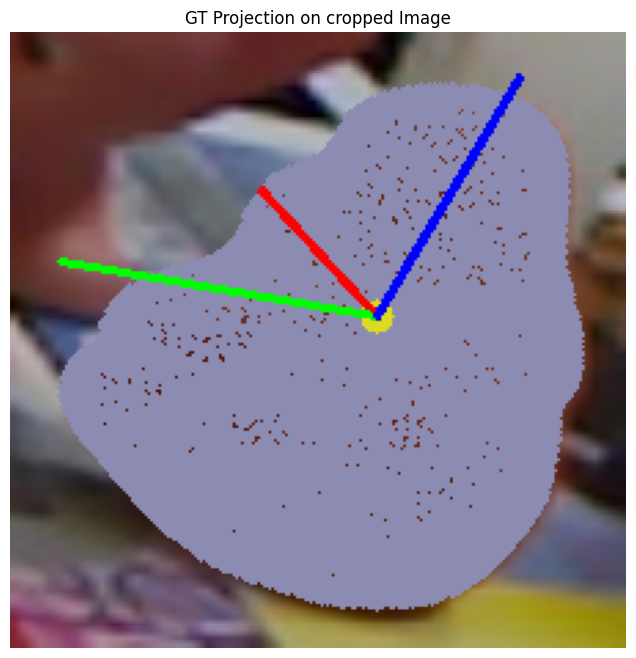

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

obj_id = 1
eval_dataset_id = "01" # 03 is missing.
PLOT_MODEL_ON_TOP = True
DRAW_MODEL_AXES = True
DRAW_OBJECT_CENTER = True

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample (image index within split)
img_idx = 0
sample_data = dataset[img_idx]
objects = sample_data['objects']               # list of dicts

# Get the object-specific data for the chosen obj_id
obj_sample = next(obj for obj in objects if obj['object_id'] == obj_id)

R_gt = obj_sample['rotation']
t_gt = obj_sample['translation']
cropped_K = obj_sample['cropped_K'].numpy()
cropped_rgb = obj_sample['cropped_rgb']

# Load 3D model
model_points = dataset.load_3D_model(obj_id)

# Project 3D model points to 2D
def project_3d_to_2d(points, K, R, t):
  transformed = points @ R.T + t
  projected = np.dot(K, transformed.T).T  # Use np.dot for matrix multiplication
  projected = projected.astype(np.float64) # Ensure correct data type
  return projected[:, :2] / projected[:, 2:3]

pts_2d = project_3d_to_2d(model_points, cropped_K, R_gt, t_gt)

def unnormalize_image(img_tensor, mean, std):
    img = img_tensor.clone().permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

# Prepare image.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# unnormalize
img_large = unnormalize_image(cropped_rgb, mean, std)
img_large = cv2.cvtColor(img_large, cv2.COLOR_RGB2BGR)

if PLOT_MODEL_ON_TOP:
  # --- Making 3D model ---
  # 1. Draw points with a more visible color and thickness
  point_color = (179, 140, 140)
  point_thickness = 2

  # 2. Draw projected points with boundary check and debug info
  for pt in pts_2d:
      x, y = int(pt[0]), int(pt[1])
      if 0 <= x < img_large.shape[1] and 0 <= y < img_large.shape[0]:
          cv2.circle(img_large, (x, y), point_thickness, point_color, -1)
      else:
          print(f"Point outside image bounds: ({x}, {y})")

if DRAW_OBJECT_CENTER:
    # Draw projected object center
    center_2d = np.dot(cropped_K, t_gt.reshape(3, 1)).flatten()
    center_2d = center_2d.astype(np.float64) # Ensure correct data type
    #center_2d = (cropped_K @ t_gt.reshape(3, 1)).flatten()
    cx = center_2d[0] / center_2d[2]
    cy = center_2d[1] / center_2d[2]
    cv2.circle(img_large, (int(cx), int(cy)), 6, (33, 218, 220), -1)


if DRAW_MODEL_AXES:
  #------Draw projected object center------


  # Define small axes in object space
  axis_length = 0.05  # meters
  axes_points = np.array([
      [0, 0, 0],  # origin
      [axis_length, 0, 0],  # X
      [0, axis_length, 0],  # Y
      [0, 0, axis_length],  # Z
  ])

  axes_2d = project_3d_to_2d(axes_points, cropped_K, R_gt, t_gt).astype(int)

  origin = tuple(axes_2d[0])
  cv2.line(img_large, origin, tuple(axes_2d[1]), (0, 0, 255), 2)   # X - Red
  cv2.line(img_large, origin, tuple(axes_2d[2]), (0, 255, 0), 2)   # Y - Green
  cv2.line(img_large, origin, tuple(axes_2d[3]), (255, 0, 0), 2)   # Z - Blue

# Show image
print(f"Projected object center: ({cx:.1f}, {cy:.1f})")
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_large, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("GT Projection on cropped Image")
plt.show()

## More experiements

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Setup paths
obj_id = 1
img_idx = 0
eval_dataset_id = "01"  # Change if needed

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")

dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample
img_idx = 0
sample = dataset[img_idx]

# Ground truth pose
R_gt = sample["rotation"].cpu().numpy()  # [3, 3]
t_gt = sample["translation"].cpu().numpy()  # [3]
obj_id = int(sample["object_id"])
org_K = sample['original_K']
cropped_K = sample['cropped_K']

print("Original intrinsic matrix K:")
print(org_K)

print("Intrinsic matrix K:")
print(sample['original_K'])

print("Translation t_gt (meters):", sample["translation"].numpy())
print("Rotation R_gt:")
print(sample["rotation"].numpy())


# Convert tensor image to RGB numpy image
rgb_tensor = sample["cropped_rgb"]  # [3, H, W]
rgb_np = rgb_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
rgb_np = (rgb_np * 255).astype(np.uint8)  # Assume [0,1] range
rgb_np = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2BGR)

# Load the original image from disk
img_path = os.path.join(dataset.rgb_dir, f"{img_idx:04d}.png")
rgb_image = np.array(Image.open(img_path).convert("RGB"))
rgb_np = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)

# 3D model points
model_points = dataset.load_3D_model(obj_id)  # [N, 3]

# Project 3D points into 2D
def project_3d_to_2d(points, K, R, t):
    transformed = points @ R.T + t
    projected = (K @ transformed.T).T
    return projected[:, :2] / projected[:, 2:3]



#R_test = R_gt.copy()
#R_test[1, :] *= -1

pts_2d = project_3d_to_2d(model_points, cropped_K, R_gt, t_gt)

# Draw on image
image_vis = rgb_np.copy()
for pt in pts_2d:
    x, y = int(pt[0]), int(pt[1])
    if 0 <= x < image_vis.shape[1] and 0 <= y < image_vis.shape[0]:
        cv2.circle(image_vis, (x, y), 2, (255, 0, 0), -1)  # Blue dots = GT

# Show
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Pose Projection")
plt.axis("off")
plt.show()


KeyError: 'rotation'

## Plotting 3D model in top of the original image

Adding model of object id 1 to list


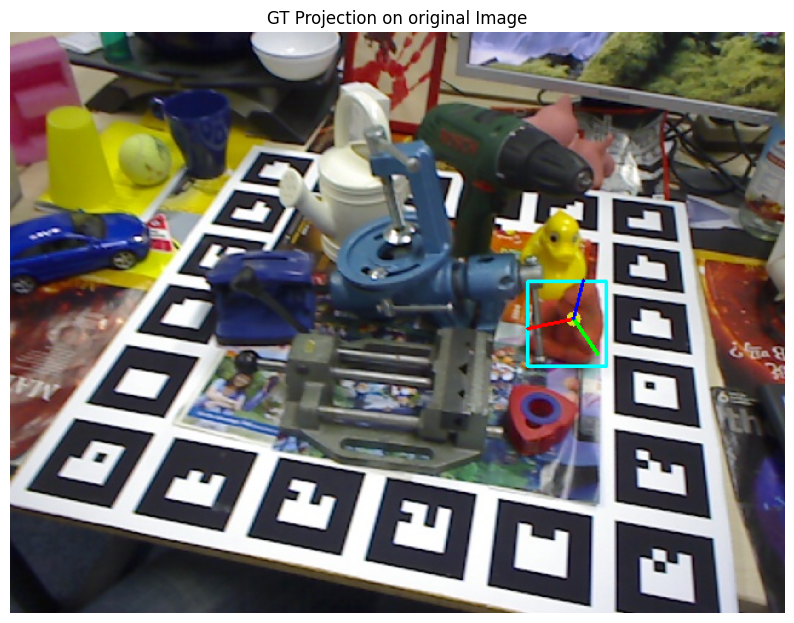

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

obj_id = 1
eval_dataset_id = "02"
DRAW_BB = True
DRAW_MODEL_AXES = True
DRAW_MODEL_ON_TOP = False
DRAW_OBJECT_CENTER = True

eval_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/data", eval_dataset_id)
models_root = os.path.join(full_project_path, "dataset/LineMOD/Linemod_preprocessed/models")
dataset = PoseEstimationDataset(eval_root, models_root)

# Load one test sample (image index within split)
img_idx = 7
sample_data = dataset[img_idx]

org_rgb = sample_data['original_rgb']          # tensor [3, H, W]
org_K = sample_data['original_K'].numpy()      # tensor → numpy
objects = sample_data['objects']               # list of dicts

# Get the object-specific data for the chosen obj_id
obj_sample = next(obj for obj in objects if obj['object_id'] == obj_id)

R_gt = obj_sample['rotation']
t_gt = obj_sample['translation']
bbox = obj_sample['bbox']

# Load 3D model
model_points = dataset.load_3D_model(obj_id)

# Project 3D model points to 2D
def project_3d_to_2d(points, K, R, t):
    transformed = points @ R.T + t
    projected = (K @ transformed.T).T
    return projected[:, :2] / projected[:, 2:3]

pts_2d = project_3d_to_2d(model_points, org_K, R_gt, t_gt)

# Prepare image
org_rgb_np = np.array(org_rgb)
image_vis = cv2.cvtColor(org_rgb_np, cv2.COLOR_RGB2BGR)

if DRAW_MODEL_ON_TOP:
    # --- Making 3D model ---
    # 1. Draw points with a more visible color and thickness
    point_color = (179, 140, 140)
    point_thickness = 2

    # 2. Draw projected points with boundary check and debug info
    for pt in pts_2d:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= x < image_vis.shape[1] and 0 <= y < image_vis.shape[0]:
            cv2.circle(image_vis, (x, y), point_thickness, point_color, -1)
        else:
            print(f"Point outside image bounds: ({x}, {y})")

if DRAW_OBJECT_CENTER:
    # Draw projected object center
    center_2d = (org_K @ t_gt.reshape(3, 1)).flatten()
    cx = center_2d[0] / center_2d[2]
    cy = center_2d[1] / center_2d[2]
    cv2.circle(image_vis, (int(cx), int(cy)), 6, (33, 218, 220), -1)

if DRAW_BB:
    # Draw GT bounding box
    x, y, w, h = bbox
    cv2.rectangle(image_vis, (x, y), (x + w, y + h), (255, 255, 0), 2)

if DRAW_MODEL_AXES:
    #------Draw projected object center------

    # Define small axes in object space
    axis_length = 0.05  # meters
    axes_points = np.array([
        [0, 0, 0],  # origin
        [axis_length, 0, 0],  # X
        [0, axis_length, 0],  # Y
        [0, 0, axis_length],  # Z
    ])

    axes_2d = project_3d_to_2d(axes_points, org_K, R_gt, t_gt).astype(int)

    origin = tuple(axes_2d[0])
    cv2.line(image_vis, origin, tuple(axes_2d[1]), (0, 0, 255), 2)   # X - Red
    cv2.line(image_vis, origin, tuple(axes_2d[2]), (0, 255, 0), 2)   # Y - Green
    cv2.line(image_vis, origin, tuple(axes_2d[3]), (255, 0, 0), 2)   # Z - Blue


# Show image
#print(f"Projected object center: ({cx:.1f}, {cy:.1f})")
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("GT Projection on original Image")
plt.show()